Repetition-5 Example
===

In [1]:
import os
from qce_interp import (
    DataManager,
    QubitIDObj,
    ParityType,
    Surface17Layer,
    IErrorDetectionIdentifier,
    ILabeledErrorDetectionIdentifier,
    ErrorDetectionIdentifier,
    LabeledErrorDetectionIdentifier,
    ISyndromeDecoder,
    ILabeledSyndromeDecoder,
    Distance5LookupTableDecoder,
    LabeledSyndromeDecoder,
)
from definitions import UNITDATA_DIR
example_file_path = os.path.join(UNITDATA_DIR, 'example_repetition_code_distance_5.hdf5')

Construct Data Manager
===
This class is responsible to construct the experiment index kernel based on metadata such as the number of QEC-rounds, involved qubits, device layout, expected initial stabilizer parities (based on prepared data-qubit state) and whether heralded initialization is used.

Note: reading a large .hdf5 file might take a few minutes. (approx. 2 minutes for 6Gb file)

In [2]:
data_manager: DataManager = DataManager.from_file_path(
    file_path=example_file_path,
    rounds=list(range(1, 60 + 1)),
    heralded_initialization=True,
    qutrit_calibration_points=True,
    involved_data_qubit_ids=[QubitIDObj('D7'), QubitIDObj('D4'), QubitIDObj('D5'), QubitIDObj('D6'), QubitIDObj('D3')],
    involved_ancilla_qubit_ids=[QubitIDObj('Z3'), QubitIDObj('Z1'), QubitIDObj('Z4'), QubitIDObj('Z2')],
    expected_parity_lookup={
        QubitIDObj('Z3'): ParityType.ODD,
        QubitIDObj('Z1'): ParityType.ODD, 
        QubitIDObj('Z4'): ParityType.ODD, 
        QubitIDObj('Z2'): ParityType.ODD,
    },
    device_layout=Surface17Layer(),
)

Processing data file: 100%|██████████| 9/9 [00:06<00:00,  1.47it/s]


Construct Error Detection Identifier
===
This class follows the `IErrorDetectionIdentifier` interface and is responsible providing processed experimental data such as:
- Binary (or ternary) classification of qubit (qutrit) measurements. 
- Post-selecting (masking) data based on heralded initialization or leakage events (2nd-state readout).
- Stabilizer parities.
- Computed parities from final data-qubit measurements.
- Stabilizer defects.

Each method output follows the following convention:
Output arrays are 3D tensors (N, M, P) where,
- N is the number of measurement repetitions.
- M is the number of stabilizer repetitions.
- P is the number of qubit elements.
    Where:
    - S is the number of stabilizer qubits.
    - D is the number of data qubits.

Note: It is possible to wrap `IErrorDetectionIdentifier` with `LabeledErrorDetectionIdentifier` to obtain the same method outputs but formatted using `xarray.DataArray`.

In [3]:
error_identifier: IErrorDetectionIdentifier = data_manager.get_error_detection_classifier(
    use_heralded_post_selection=True,
    use_computational_parity=True,
)

# Optional labeled wrapper
labeled_error_identifier: ILabeledErrorDetectionIdentifier = LabeledErrorDetectionIdentifier(
    error_identifier,
)

Construct Basic LUT Decoder
===
From this point we can write decoder functionality that uses `IErrorDetectionIdentifier` as an interface to the experiment data. The decoder requires no knowledge for example on post-selection and state classification.
The following LUT decoder class implements a general `ISyndromeDecoder`.

In [4]:
decoder: ISyndromeDecoder = Distance5LookupTableDecoder(
    error_identifier,
)

# Optional labeled wrapper
labeled_decoder: ILabeledSyndromeDecoder = LabeledSyndromeDecoder(
    decoder
)

Visualization
===
Lets use this framework to visualize some commong metrics

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Computational parity and refocusing corrected State'}, ylabel='Rounds'>)

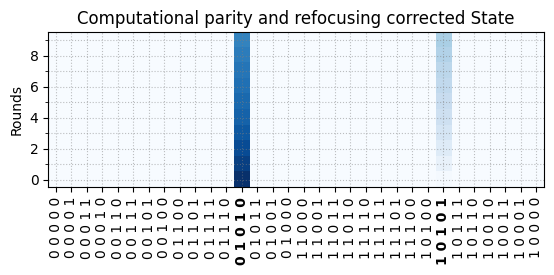

In [5]:
from qce_interp.visualization import plot_state_evolution

plot_state_evolution(
    syndrome_decoder=decoder,
    target_state=[0, 1, 0, 1, 0],
    included_rounds=list(range(1, 11)),
)

(<Figure size 640x480 with 3 Axes>, <Axes: >)

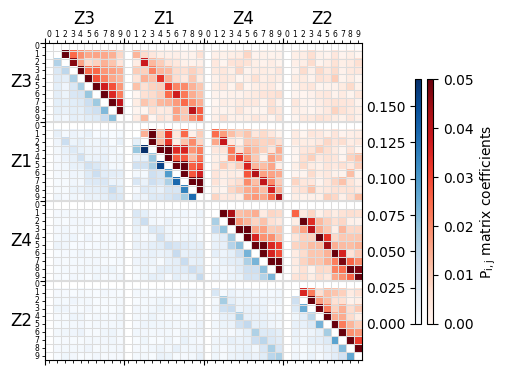

In [6]:
from qce_interp.visualization import plot_pij_matrix

plot_pij_matrix(
    error_identifier=error_identifier,
    included_rounds=list(range(1, 11)),
)